In [2]:
import io
import boto3
import configparser
import os
from tqdm import tqdm

import numpy as np
import pandas as pd

from datetime import datetime

import warnings
warnings.filterwarnings(action="ignore")

import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [3]:
def get_credential_info(section_name):
    
    parser = configparser.ConfigParser()
    parser.read('./config.ini')
    access_key = parser.get(section_name, "access_key")
    secret_key = parser.get(section_name, "secret_key")
    
    return access_key, secret_key

def get_s3_file_list(section_name, bucket_name, prefix):
    
    access_key, secret_key = get_credential_info(section_name)
    
    s3 = boto3.client('s3',
                      aws_access_key_id=access_key,
                      aws_secret_access_key=secret_key)

    contents = s3.list_objects(Bucket=bucket_name, Prefix=prefix)["Contents"]
    
    return contents

def get_s3_file(section_name, bucket_name, file, cmp="infer"):
    
    access_key, secret_key = get_credential_info(section_name)
    
    s3 = boto3.client('s3',
                      aws_access_key_id=access_key,
                      aws_secret_access_key=secret_key)
    
    obj = s3.get_object(Bucket=bucket_name, Key=file)
    
    df = pd.read_csv( io.BytesIO( obj["Body"].read() ), compression=cmp) 
    
    return df

def write_csv_to_s3(section_name, bucket_name, file_path, data):
    
    access_key, secret_key = get_credential_info(section_name)
    
    s3 = boto3.client('s3',
                      aws_access_key_id=access_key, 
                      aws_secret_access_key=secret_key)

    s3.put_object(
        Body=data.to_csv(index=False).encode(),
        Bucket=bucket_name, Key=file_path)

In [4]:
section_name = "aws_boto_credentials"
bucket_name = "ev-depreciation-model"

## Concat daily file to make monthly

In [19]:
dates = pd.date_range("2020-11-01", "2022-04-01", freq="MS",).strftime("%Y%m")

for date in dates:
    prefix = "pmgrow/"+date
    fpath_list = get_s3_file_list(section_name, bucket_name, prefix)
    
    df_mth = pd.DataFrame()
    for fpath in fpath_list:
        
        key = fpath["Key"]
        file = key.split("/")[-1]
        print(file, end=": ")
        
        try:
            if file[-2:]=='gz':
                cmp="gzip"
            else:
                cmp="infer"
            
            df = get_s3_file(section_name, bucket_name, key, cmp=cmp)
            print(df.shape)
            df_mth = pd.concat([df_mth, df], axis=0)
        except:
            print("Missing")
            continue
    
    print("----Complete----")
    print(date, df_mth.shape)
    spath = f"pmgrow/concat-monthly/{date}.csv"
    write_csv_to_s3(section_name, bucket_name, spath, df_mth)
    print("----------------")

2020-11-01-2020-11-02.csv.gz: Missing
2020-11-02-2020-11-03.csv.gz: (27359, 40)
2020-11-03-2020-11-04.csv.gz: (44827, 40)
2020-11-04-2020-11-05.csv.gz: (41889, 40)
2020-11-05-2020-11-06.csv.gz: (53646, 40)
2020-11-06-2020-11-07.csv.gz: (44485, 40)
2020-11-07-2020-11-08.csv.gz: (4218, 40)
2020-11-08-2020-11-09.csv.gz: (2271, 40)
2020-11-09-2020-11-10.csv.gz: (42969, 40)
2020-11-10-2020-11-11.csv.gz: (49629, 40)
2020-11-11-2020-11-12.csv.gz: (36878, 40)
2020-11-12-2020-11-13.csv.gz: (43796, 40)
2020-11-13-2020-11-14.csv.gz: (47533, 40)
2020-11-14-2020-11-15.csv.gz: (6906, 40)
2020-11-15-2020-11-16.csv.gz: (4597, 40)
2020-11-16-2020-11-17.csv.gz: (44521, 40)
2020-11-17-2020-11-18.csv.gz: (41306, 40)
2020-11-18-2020-11-19.csv.gz: (52158, 40)
2020-11-19-2020-11-20.csv.gz: (47276, 40)
2020-11-20-2020-11-21.csv.gz: (40249, 40)
2020-11-21-2020-11-22.csv.gz: (8547, 40)
2020-11-22-2020-11-23.csv.gz: (1793, 40)
2020-11-23-2020-11-24.csv.gz: (48819, 40)
2020-11-24-2020-11-25.csv.gz: (52540, 40)
20

In [21]:
df_mth.sample(10)

,name,tags,time,accpe,auxbv,bc,bv,bw,cce,cde,...,t_12,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,topic
37391,motor_vehicle_info,NaN,1649643817536000000,0.0,13.0,0.500000,353.700012,176.850006,4457.8,4367.8,...,NaN,20,20,20,20,20,20,20,NaN,/r/ph/v/34_5080/info
19226,motor_vehicle_info,NaN,1648788496722000000,0.0,14.5,-3.400000,390.600006,-1328.040039,5325.5,5153.0,...,11.0,11,11,12,11,11,11,11,12.0,/r/ph/v/69_1581/info
14265,motor_vehicle_info,NaN,1649222941918000000,13.5,14.0,-83.199997,361.600006,-30085.119141,5782.8,5656.7,...,17.0,17,18,19,17,18,18,17,18.0,/r/ph/v/69_1763/info
17229,motor_vehicle_info,NaN,1649138002478000000,0.0,13.2,0.000000,372.899994,0.000000,14167.1,13820.9,...,NaN,15,15,14,15,15,15,15,NaN,/r/ph/v/34_5066/info
11087,motor_vehicle_info,NaN,1649746617146000000,3.0,14.4,-21.299999,366.200012,-7800.060059,8170.6,8006.5,...,27.0,27,27,28,27,27,27,27,28.0,/r/ph/v/06_7528/info
13914,motor_vehicle_info,NaN,1649910024305000000,11.0,14.5,1.100000,343.100006,377.410004,1547.2,1480.2,...,11.0,11,11,11,11,11,11,12,11.0,/r/ph/v/41_4639/info
8404,motor_vehicle_info,NaN,1649565147863000000,4.0,14.5,8.700000,371.100006,3228.570068,6792.0,6589.9,...,22.0,22,23,24,22,23,23,22,23.0,/r/ph/v/69_1695/info
33959,motor_vehicle_info,NaN,1649818273305000000,7.4,13.9,1.100000,352.799988,388.079987,14600.3,14321.8,...,16.0,16,16,17,18,16,16,16,16.0,/r/ph/v/42_1174/info
24471,motor_vehicle_info,NaN,1649217691605000000,7.4,14.0,8.800000,345.500000,3040.400146,5638.1,5449.9,...,17.0,18,17,17,17,18,17,17,17.0,/r/ph/v/42_1354/info
32023,motor_vehicle_info,NaN,1649651043745000000,0.0,14.5,2.100000,363.100006,762.509949,8151.9,7989.4,...,24.0,24,24,24,24,24,24,24,24.0,/r/ph/v/06_7528/info


## Read monthly data

In [5]:
df = pd.DataFrame()
cols = ["topic", "time", "drivespeed", "soh"]

dates = pd.date_range("2020-11-01", "2022-04-01", freq="MS",).strftime("%Y%m")
for date in dates:
    fpath = f"pmgrow/concat-monthly/{date}.csv"
    df_tmp = get_s3_file(section_name, bucket_name, fpath)
    df_tmp["topic"] = df_tmp["topic"].apply(lambda x: x.split("/")[-2])
    print(f"{date} : {df_tmp.shape}", end=" -> ")
    
    df = pd.concat([df, df_tmp[cols]], axis=0)
    print(df.shape)

202011 : (999527, 40) -> (999527, 4)
202012 : (988186, 40) -> (1987713, 4)
202101 : (819003, 40) -> (2806716, 4)
202102 : (638686, 40) -> (3445402, 4)
202103 : (951395, 40) -> (4396797, 4)
202104 : (1037686, 40) -> (5434483, 4)
202105 : (738216, 40) -> (6172699, 4)
202106 : (825135, 40) -> (6997834, 4)
202107 : (1119799, 40) -> (8117633, 4)
202108 : (1277727, 40) -> (9395360, 4)
202109 : (1030667, 40) -> (10426027, 4)
202110 : (1482460, 51) -> (11908487, 4)
202111 : (1794845, 46) -> (13703332, 4)
202112 : (963687, 40) -> (14667019, 4)
202201 : (851902, 40) -> (15518921, 4)
202202 : (815111, 40) -> (16334032, 4)
202203 : (546319, 40) -> (16880351, 4)
202204 : (493111, 40) -> (17373462, 4)


In [7]:
df["time"] = pd.to_datetime(df["time"])

## Data cleansing

In [41]:
df_pre = df.copy()

In [45]:
# 1. all points are zero or nan
drop_topic = ["11_2222", "vcu"] 

# 2. soh consists of all missing values
soh_cnt = df_pre.groupby("topic")["soh"].count()
soh_miss = soh_cnt[soh_cnt==0].index.tolist()
drop_topic = drop_topic+soh_miss

print(df_pre.topic.nunique())
df_pre = df_pre[~df_pre.topic.isin(drop_topic)]
print(df_pre.shape)

44
(14775817, 4)


In [76]:
df_pre.topic.nunique()

31

In [47]:
df_pre.groupby("topic")["soh"].describe()

,count,mean,std,min,25%,50%,75%,max
topic,,,,,,,,
06_7528,552036.0,100.000000,0.000000,100.0,100.0,100.0,100.0,100.0
06_7642,548003.0,100.000000,0.000000,100.0,100.0,100.0,100.0,100.0
06_7665,394818.0,100.000000,0.000000,100.0,100.0,100.0,100.0,100.0
06_7793,640172.0,100.000000,0.000000,100.0,100.0,100.0,100.0,100.0
34_4794,359523.0,109.989291,1.085283,0.0,110.0,110.0,110.0,110.0
34_5002,545659.0,72.824647,16.255163,36.0,80.0,80.0,80.0,80.0
34_5020,861010.0,110.000000,0.000000,110.0,110.0,110.0,110.0,110.0
34_5066,431417.0,75.385360,5.915909,62.0,78.0,78.0,78.0,78.0
34_5069,32474.0,76.000000,0.000000,76.0,76.0,76.0,76.0,76.0


In [91]:
df_pre[df_pre.soh>0].groupby("topic")["soh"].describe()

,count,mean,std,min,25%,50%,75%,max
topic,,,,,,,,
06_7528,552036.0,100.000000,0.000000,100.0,100.0,100.0,100.0,100.0
06_7642,548003.0,100.000000,0.000000,100.0,100.0,100.0,100.0,100.0
06_7665,394818.0,100.000000,0.000000,100.0,100.0,100.0,100.0,100.0
06_7793,640172.0,100.000000,0.000000,100.0,100.0,100.0,100.0,100.0
34_4794,359488.0,110.000000,0.000000,110.0,110.0,110.0,110.0,110.0
34_5002,545659.0,72.824647,16.255163,36.0,80.0,80.0,80.0,80.0
34_5020,861010.0,110.000000,0.000000,110.0,110.0,110.0,110.0,110.0
34_5066,431417.0,75.385360,5.915909,62.0,78.0,78.0,78.0,78.0
34_5069,32474.0,76.000000,0.000000,76.0,76.0,76.0,76.0,76.0


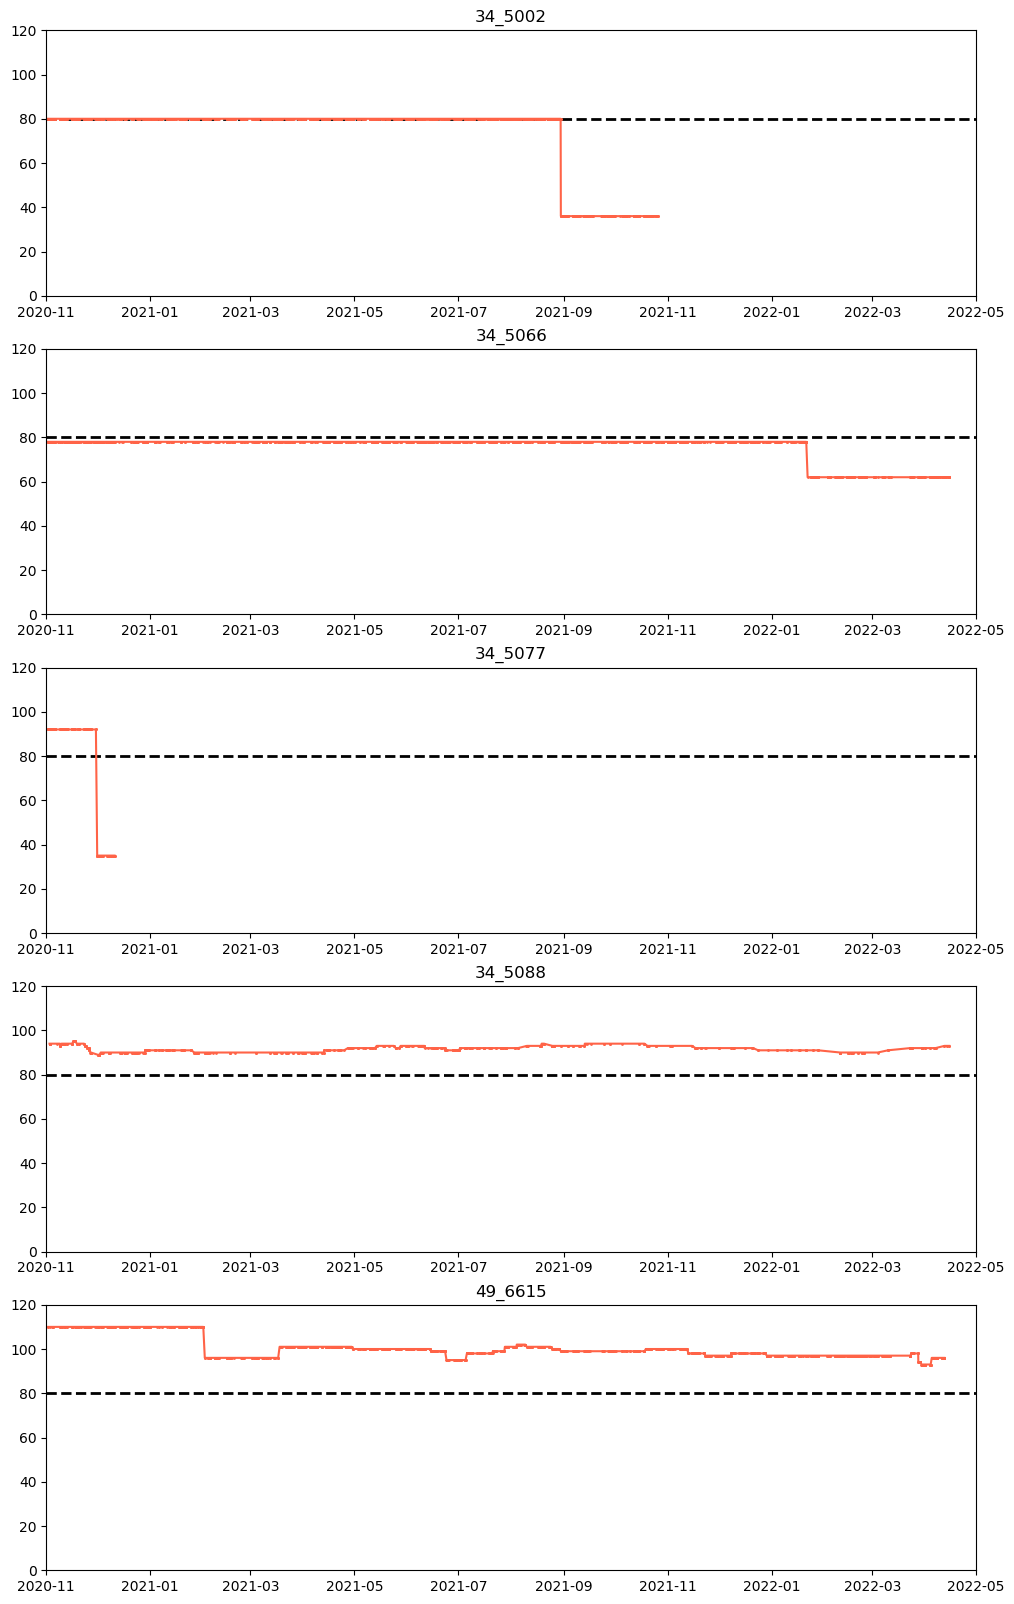

In [89]:
tps = ["34_5002", "34_5066", "34_5077", "34_5088", "49_6615"]

nrows=len(tps)
fig, axs = plt.subplots(figsize=(12, 4*nrows), nrows=nrows)

for tp, ax in zip(tps, axs):
    
    df_tst = df_pre[(df_pre.topic==tp) & (df_pre.soh!=0)]
    df_tst_min = df_tst.sort_values("time").copy()
    
    df_tst_min["time"] = df_tst_min["time"].apply(lambda x: x.strftime("%Y-%m-%d %H"))
    df_tst_min.drop_duplicates("time", keep="last", inplace=True)
    df_tst_min["time"] = pd.to_datetime(df_tst_min["time"])
    
    dt1, dt2 = datetime(2020,11,1), datetime(2022,5,1)

    ax.plot(df_tst_min.time, df_tst_min.soh, marker="o", ms=1, color="tomato")
    ax.hlines(80, dt1, dt2, color="k", linestyle="--", lw=2)
    ax.set_title(tp)
    ax.set_xlim(dt1, dt2)
    ax.set_ylim(0, 120)
    
plt.show()